In [1]:
import sqlite3
from requests.exceptions import Timeout, ConnectionError
import time
from time import sleep
import pandas as pd
import pyodbc
import spacy
import re
import numpy as np
import nltk 
from nltk.corpus import stopwords

import wordcloud
from wordcloud import WordCloud


from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

In [2]:
# Setting the connection strings
server = 'tcp:isye-6420-project.database.windows.net,1433' 
database = 'topic_modelling' 
username = 'project_administrator' 
password = 'isye_6420_admin' 
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
#SQLite cursor
c = conn.cursor()

In [3]:
# Method to read the twitter messages into the pandas dataframe
def read_sql():
    train_data =  pd.read_sql_query('select [tweet_text], [Political_party] from tweets_raw', conn) 
    return(train_data)

In [4]:
# Step 1 : Data Loading 
    
# Executing method to read twitter messages into dataframe
train_data = read_sql()
    

In [5]:
# Step 2: Data Cleaning 

# print the train_data column names 
print(train_data.columns)

# Load the regular expression library
#  Remove URLs
train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
# Remove punctuation
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('[,\.!?@]', '', x))
# Remove punctuation
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'']', '', x))
# Convert the titles to lowercase
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: x.lower())
# Removing the word 'amp' 
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('amp', '', x))

#remove times pm
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('\d+pm', '', x))


Index(['tweet_text', 'Political_party'], dtype='object')


In [6]:
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("it's",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("n't",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("'",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("-",'', x))

In [7]:
# 5. Removing Stopwords 
STOPWORDS = set(stopwords.words('english','spanish'))
def remove(text,wordset=STOPWORDS):
    splits = text.split()
    result=[]
    for split in splits:
        if split not in wordset:
            result.append(split.strip())
    return (" ".join(result))        

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x))


In [8]:
#  6. To retain only the Nouns and Adjectives in every tweet 

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    doc = nlp(texts) 
    texts_out = " ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out     

# Do lemmatization keeping only noun, adj parts of speech (POS)
train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: lemmatization(x, allowed_postags=['NOUN', 'ADJ']))


In [9]:
# 7. To eliminate additional words 

eliminate_words = {'today', 'year', 'people', 'time', 'great', 'day', 'morning', 'evening', 'community', 'important',
                   'many', 'family', 'sure', 'visit', 'https', 'new', 'work', 'proud', 'thank', 'good', 'way', 'help',
                   'need', 'member', 'week', 'nation', 'support', 'last', 'effort', 'yesterday', 'news', 'watch', 'state',
                   'safe', 'happy', 'birthday', 'colleague', 'tonight', 'part', 'much', 'now', 'country', 'leader', 'program',
                   'congratulation', 'conversation', 'fact', 'government', 'house', 'right', 'tomorrow', 'question', 'long',
                   'public', 'big', 'million', 'benefit', 'information', 'report' , 'friend', 'life', 'bad' , 'word', 'true',
                   'woman', 'man', 'local', 'action', 'resource', 'high','school', 'opportunity', 'town', 'event', 'meeting',
                   'tune', 'pm', 'student', 'live', 'discussion', 'discuss', 'child', 'world', 'policy', 'condition', 'hand',  
                   'office', 'place', 'resident', 'site' , 'concern', 'city', 'free', 'congressional', 'WORKER', 'history',
                   'wonderful', 'team', 'update', 'facebook', 'minute', 'op', 'water', 'food', 'hour', 'pm', 
                   'thing', 'art', 'folk', 'annual', 'prayer', 'thought', 'heart', 'statement', 'story', 'special', 'pre',
                   'honor', 'young', 'neighbor', 'night', 'district', 'late', 'moment', 'case', 'census', 'person', 'voice', 
                   'wrong',  'share', 'victory', 'grateful', 'century', 'kid', 'difficult', 'afternoon', 'love', 'youth', 
                   'fellow', 'mother',  'comment', 'official','p','m','p m', 'crisis'}



train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x, wordset=eliminate_words ))

In [10]:
extra_words = {'today','thank','11','wa','con','por','del','los','que','para','en','el','la','de','sure','know','make','going','your',
'about','they','ve','we','re','ing','im','proud','ago','act','tonight','tune','live','morning','listen','join','discuss',
'forward','great','will','see','must','tomorrow','day','one','host','hall','god','bless','about','happy','birthday',
'birth','fireside','chat','celebrating','christmas','roshhashanah','graduation','high','celebration','yom kippur','time',
'year','new','easter','art','competition','guest','hosting','seanhannity','facebook','ill','wolfblitzer','joining',
'fridayswithfrank','town','hold','sunday','night','thanks','watching','point','good','nightclub','camdencountynj',
'weekly','update','page','yom','kippur','congratulations','congratulation','eaglej','scout','weeks','week','todays',
'daily','yesterday','youll','cnnsitrom','shortly','minute','happening','soon','foxnews','900p','ne02','gobierno',
'estados','unidos','visite','nuestra','pagina ','federales','estados','agencias','kbtxnews','totally','agree','wtaw1620',
'icymi','segment','coming','soon','et','praying','speedy','frequently','asked','question','thought','share','noon','newsletter',
'clicking','exactly','right','1000p','1100p','wishing','algal','bloom','app','receive','245th','244th','start','hour',
'olg','youve','loudobbs','foxbusiness','free','feel','passionate','west','palm','sign','link','va','inside','ill',
'foxandfriend','valley','watch','informacion','espanol','acerca','sus','link','servicios','pagina','ill','foxandfriend',
'valley','watch','informacion','espanol','acerca','kwtx','ne03', 'quid','foxnewsnight','pagina','espanol','quid','passover',
'simonradio1776','whoradio', '800wvhu','ill3'}

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x,extra_words))


In [11]:
def replace_synonyms(text):
    splits = text.split()
    result=[]
    for split in splits:
        if split in synonyms:
            result.append(synonyms[split])
        else:
            result.append(split)
    return (" ".join(result))        

#replace synonyms
synonyms = {'donald':'trump','realdonaldtrump':'trump','joebiden':'biden'}

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: replace_synonyms(x))


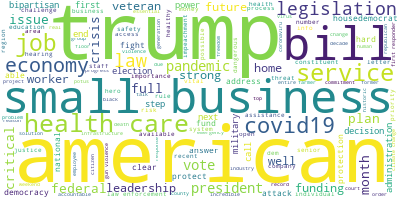

In [12]:
# Step 3: Exploratory Analysis 

# Import the wordcloud library


# Spliting across party Lines 
#train_data_dem = train_data.loc[train_data['Political_party'] == "Democratic Party"]
#train_data_rep = train_data.loc[train_data['Political_party'] == "Republican Party"]
train_data = train_data.loc[(train_data['Political_party'] == "Republican Party") | (train_data['Political_party'] == "Democratic Party") ]


# Join the different processed tweets together.
long_string = ','.join(list(train_data['tweet_text'].values))
#long_string_rep = ','.join(list(train_data_rep['tweet_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=10, contour_color='steelblue')
#wordcloud_rep = WordCloud(background_color="white", max_words=5000, contour_width=10, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the Democratic word cloud
wordcloud.to_image()


In [13]:
'''
# Generate a word cloud
wordcloud_rep.generate(long_string_rep)
# Visualize the word cloud
wordcloud_rep.to_image()'''

'\n# Generate a word cloud\nwordcloud_rep.generate(long_string_rep)\n# Visualize the word cloud\nwordcloud_rep.to_image()'

In [14]:
# Step 4: Data Preparation before training Model 

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()




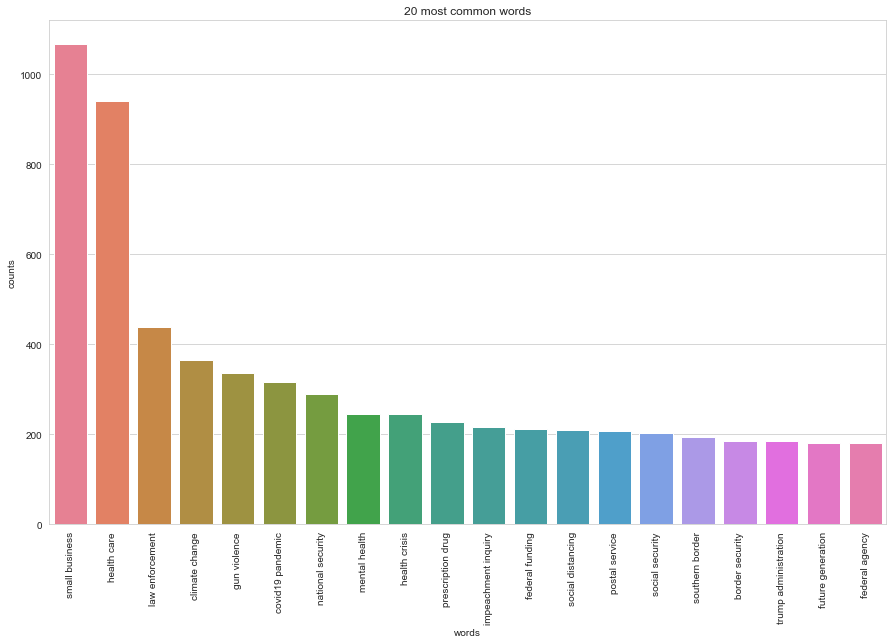

In [15]:
# 20_most_common_words in Democrats tweets
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=10)
hv.transform(train_data["tweet_text"])   

from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer= TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english', max_features= 1000)
# Fit and transform the processed tweets
count_data= count_vectorizer.fit_transform(train_data['tweet_text'])
# Visualise the 20 most common words
plot_20_most_common_words(count_data, count_vectorizer)

In [16]:
'''
# 20_most_common_words in Republic tweets
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=10)
hv.transform(train_data_rep["tweet_text"])   

from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer_rep = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english', max_features= 1000)
# Fit and transform the processed tweets
count_data_rep = count_vectorizer_rep.fit_transform(train_data_rep['tweet_text'])
# Visualise the 20 most common words
plot_20_most_common_words(count_data_rep, count_vectorizer_rep)'''

'\n# 20_most_common_words in Republic tweets\nfrom sklearn.feature_extraction.text import HashingVectorizer\nhv = HashingVectorizer(n_features=10)\nhv.transform(train_data_rep["tweet_text"])   \n\nfrom sklearn.feature_extraction.text import TfidfVectorizer\ncount_vectorizer_rep = TfidfVectorizer(analyzer=\'word\', token_pattern=r\'\\w{1,}\', ngram_range=(2,3),use_idf=True, lowercase=True, strip_accents="ascii", stop_words=\'english\', max_features= 1000)\n# Fit and transform the processed tweets\ncount_data_rep = count_vectorizer_rep.fit_transform(train_data_rep[\'tweet_text\'])\n# Visualise the 20 most common words\nplot_20_most_common_words(count_data_rep, count_vectorizer_rep)'

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english')
#count_vectorizer_repub =TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english')

# Calculate DocTerm Matrices
count_data = count_vectorizer.fit_transform(train_data['tweet_text'])
#count_data_repub = count_vectorizer_repub.fit_transform(train_data_rep['tweet_text'])


In [18]:
from gensim import corpora
#Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Create Dictionary
text=[[text for text in doc.split()] for doc in train_data['tweet_text']]
dictionary= corpora.Dictionary(text)
corpus=[dictionary.doc2bow(text) for text in text]


In [19]:
'''
#Build manual tokenized topics
def TokenTopics(DocTerm, TopicAffinity,NumTerms=10):
    result=[]
    for i,topic in enumerate(TopicAffinity):
        result.append([DocTerm.get_feature_names()[i] for i in topic.argsort()[-NumTerms:]]) 
    return result

def CalculateCoherence(corpus1,dictionary1,text1,tt,coherence1='c_v'):
    cm=0
    if coherence1[0]=='u':
        cm = CoherenceModel(topics=tt, corpus=corpus1, dictionary=dictionary1, coherence=coherence1,processes=-1)    
    else: 
        cm = CoherenceModel(topics=tt, texts=text1, dictionary=dictionary1, coherence=coherence1,processes=-1)
    return cm.get_coherence()


'''

"\n#Build manual tokenized topics\ndef TokenTopics(DocTerm, TopicAffinity,NumTerms=10):\n    result=[]\n    for i,topic in enumerate(TopicAffinity):\n        result.append([DocTerm.get_feature_names()[i] for i in topic.argsort()[-NumTerms:]]) \n    return result\n\ndef CalculateCoherence(corpus1,dictionary1,text1,tt,coherence1='c_v'):\n    cm=0\n    if coherence1[0]=='u':\n        cm = CoherenceModel(topics=tt, corpus=corpus1, dictionary=dictionary1, coherence=coherence1,processes=-1)    \n    else: \n        cm = CoherenceModel(topics=tt, texts=text1, dictionary=dictionary1, coherence=coherence1,processes=-1)\n    return cm.get_coherence()\n\n\n"

In [20]:
'''
#Try different topic sizes, parameters
coherence_dems = dict()

for a in range(5,25):
    
    print(a)
    
    nmf_demo = NMF(n_components=a, random_state=42, max_iter=1000, solver='cd',alpha=.1, l1_ratio=.5)
    nmf_demo.fit(count_data_demo)
    tt = TokenTopics(count_vectorizer_demo,nmf_demo.components_)
    
    label='p'+str(a)
    coherence_dems[label]=CalculateCoherence(corpus_dems,dictionary_dems,text_dems,tt,'c_v')
'''    
    

"\n#Try different topic sizes, parameters\ncoherence_dems = dict()\n\nfor a in range(5,25):\n    \n    print(a)\n    \n    nmf_demo = NMF(n_components=a, random_state=42, max_iter=1000, solver='cd',alpha=.1, l1_ratio=.5)\n    nmf_demo.fit(count_data_demo)\n    tt = TokenTopics(count_vectorizer_demo,nmf_demo.components_)\n    \n    label='p'+str(a)\n    coherence_dems[label]=CalculateCoherence(corpus_dems,dictionary_dems,text_dems,tt,'c_v')\n"

In [21]:
#coherence_score = list(coherence_dems.values())
#coherence_score

In [22]:
'''
# Show graph
x = range(5,25)
plt.plot(x, coherence_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
'''

'\n# Show graph\nx = range(5,25)\nplt.plot(x, coherence_score)\nplt.xlabel("Number of Topics")\nplt.ylabel("Coherence score")\nplt.legend(("coherence_values"), loc=\'best\')\nplt.show()\n'

In [25]:
lda= LDA(n_components=16, n_jobs=-1, doc_topic_prior=0.01, topic_word_prior=0.01, learning_method='batch', learning_decay=0.5, learning_offset=10.0, max_iter=25, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, verbose=0)
lda_result=lda.fit_transform(count_data)

In [26]:
terms = count_vectorizer.get_feature_names()
topic= dict()

for i, comp in enumerate(lda.components_):
    print_topic = [] 
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    label = "topic_" + str(i)
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print_topic.append(t[0])
    print(print_topic)
    topic[label] = print_topic[0] + '-' + print_topic[1] + '-' + print_topic[2]
    

Topic 0: 
['election', 'vote', 'trump', 'democracy', 'mail', 'ballot', 'voter', 'voting', 'foreign', 'power']
Topic 1: 
['service', 'sacrifice', 'veteran', 'freedom', 'brave', 'equality', 'hero', 'anniversary', 'civil', 'responder']
Topic 2: 
['border', 'immigration', 'immigrant', 'crisis', 'security', 'wall', 'southern', 'complete', 'illegal', 'trump']
Topic 3: 
['impeachment', 'police', 'law', 'american', 'president', 'justice', 'officer', 'trump', 'investigation', 'enforcement']
Topic 4: 
['foxnew', 'jewish', 'black', 'budget', 'floor', 'abortion', 'military', 'baby', 'faith', 'brother']
Topic 5: 
['violence', 'gun', 'testing', 'website', 'check', 'legislation', 'covid19', 'interested', 'academy', 'background']
Topic 6: 
['mask', 'covid19', 'social', 'virus', 'spread', 'home', 'distancing', 'health', 'healthy', 'disease']
Topic 7: 
['job', 'economy', 'unemployment', 'teacher', 'rate', 'strong', 'education', 'month', 'american', 'growth']
Topic 8: 
['worker', 'wage', 'pleasure', 'pay

In [ ]:
topic

In [31]:
pd.options.display.float_format = '{:,.16f}'.format
topic_encoded_df = pd.DataFrame(lda_result, columns = ["topic_0", "topic_1", "topic_2", "topic_3","topic_4","topic_5", "topic_6", "topic_7", "topic_8", "topic_9", "topic_10", "topic_11","topic_12","topic_13","topic_14","topic_15"])
topic_encoded_df["probable_Topic"] = topic_encoded_df.idxmax(axis=1)
topic_encoded_df["Topic_Probability"] = topic_encoded_df.max(axis=1)
topic_encoded_df["documents"] = train_data['tweet_text'].values
topic_encoded_df["probable_Topic"].replace(topic, inplace=True)
display(topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]])

,documents,probable_Topic,Topic_Probability
0,,election-vote-trump,0.0625000000000000
1,single climate presidential debate letter deba...,election-vote-trump,0.4945004466629486
2,doubt demconvention,worker-wage-pleasure,0.5024616531699587
3,next generation democrat service future first ...,worker-wage-pleasure,0.9444401143976985
4,dear legacy vote vote vote plan vote,election-vote-trump,0.5747067140808761
...,...,...,...
101794,goodnew company manufacturing job,energy-infrastructure-trade,0.9271041273312590
101795,freedom restore economy american dream calm de...,service-sacrifice-veteran,0.4504405214573570
101796,hearing clear defend republican justice scotus...,impeachment-police-law,0.9424360714714014
101797,abortion covid19 prevent abortion reaction cov...,recovery-mental-health,0.5891087795509158


In [32]:
topic_model = topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]]

In [33]:
'''
#count_data_repub

# Create Dictionary
text_repub=[[text for text in doc.split()] for doc in train_data_rep['tweet_text']]
dictionary_repub = corpora.Dictionary(text_repub)
corpus_repub=corpus = [dictionary_repub.doc2bow(text) for text in text_repub]
'''

"\n#count_data_repub\n\n# Create Dictionary\ntext_repub=[[text for text in doc.split()] for doc in train_data_rep['tweet_text']]\ndictionary_repub = corpora.Dictionary(text_repub)\ncorpus_repub=corpus = [dictionary_repub.doc2bow(text) for text in text_repub]\n"

In [34]:
'''
#Try different topic sizes, parameters
coherence_repub = dict()

for a in range(5,25):
    
    print(a)
    
    nmf_repub = NMF(n_components=a, random_state=42, max_iter=1000, solver='cd',alpha=.1, l1_ratio=.5)
    nmf_repub.fit(count_data_repub)
    tt = TokenTopics(count_vectorizer_repub,nmf_repub.components_)
    
    label='p'+str(a)
    coherence_repub[label]=CalculateCoherence(corpus_repub,dictionary_repub,text_repub,tt,'c_v')
    
''' 

"\n#Try different topic sizes, parameters\ncoherence_repub = dict()\n\nfor a in range(5,25):\n    \n    print(a)\n    \n    nmf_repub = NMF(n_components=a, random_state=42, max_iter=1000, solver='cd',alpha=.1, l1_ratio=.5)\n    nmf_repub.fit(count_data_repub)\n    tt = TokenTopics(count_vectorizer_repub,nmf_repub.components_)\n    \n    label='p'+str(a)\n    coherence_repub[label]=CalculateCoherence(corpus_repub,dictionary_repub,text_repub,tt,'c_v')\n    \n"

In [35]:
'''
coherence_score = list(coherence_repub.values())
coherence_score
'''

'\ncoherence_score = list(coherence_repub.values())\ncoherence_score\n'

In [36]:
'''
# Show graph
x = range(5,25)
plt.plot(x, coherence_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
'''

'\n# Show graph\nx = range(5,25)\nplt.plot(x, coherence_score)\nplt.xlabel("Number of Topics")\nplt.ylabel("Coherence score")\nplt.legend(("coherence_values"), loc=\'best\')\nplt.show()\n'

In [37]:
#Train final model
#lda_repub = LDA(n_components=12, n_jobs=-1, doc_topic_prior=0.01, topic_word_prior=0.01, learning_method='batch', learning_decay=0.5, learning_offset=10.0, max_iter=25, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, verbose=0)
#lda_rep=lda_repub.fit_transform(count_data_repub)  

In [38]:
'''
terms = count_vectorizer_repub.get_feature_names()
topic_reps = dict()

for i, comp in enumerate(lda_repub.components_):
    print_topic = [] 
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    label = "topic_" + str(i)
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print_topic.append(t[0])
    print(print_topic)
    topic_reps[label] = print_topic[0] + '-' + print_topic[1] + '-' + print_topic[2]    
'''

'\nterms = count_vectorizer_repub.get_feature_names()\ntopic_reps = dict()\n\nfor i, comp in enumerate(lda_repub.components_):\n    print_topic = [] \n    terms_comp = zip(terms, comp)\n    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]\n    label = "topic_" + str(i)\n    print("Topic "+str(i)+": ")\n    for t in sorted_terms:\n        print_topic.append(t[0])\n    print(print_topic)\n    topic_reps[label] = print_topic[0] + \'-\' + print_topic[1] + \'-\' + print_topic[2]    \n'

In [39]:
#topic_reps

In [40]:
'''
pd.options.display.float_format = '{:,.16f}'.format
topic_encoded_df = pd.DataFrame(lda_rep, columns = ["topic_0", "topic_1", "topic_2", "topic_3","topic_4","topic_5", "topic_6", "topic_7","topic_8","topic_9","topic_10","topic_11"])
topic_encoded_df["probable_Topic"] = topic_encoded_df.idxmax(axis=1)
topic_encoded_df["Topic_Probability"] = topic_encoded_df.max(axis=1)
topic_encoded_df["documents"] = train_data.loc[train_data['Political_party'] == "Republican Party"]['tweet_text'].values
topic_encoded_df["probable_Topic"].replace(topic_reps, inplace=True)
display(topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]])
'''


'\npd.options.display.float_format = \'{:,.16f}\'.format\ntopic_encoded_df = pd.DataFrame(lda_rep, columns = ["topic_0", "topic_1", "topic_2", "topic_3","topic_4","topic_5", "topic_6", "topic_7","topic_8","topic_9","topic_10","topic_11"])\ntopic_encoded_df["probable_Topic"] = topic_encoded_df.idxmax(axis=1)\ntopic_encoded_df["Topic_Probability"] = topic_encoded_df.max(axis=1)\ntopic_encoded_df["documents"] = train_data.loc[train_data[\'Political_party\'] == "Republican Party"][\'tweet_text\'].values\ntopic_encoded_df["probable_Topic"].replace(topic_reps, inplace=True)\ndisplay(topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]])\n'

In [41]:
'''
repub_topic_model = topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]]
print(repub_topic_model)
'''

'\nrepub_topic_model = topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]]\nprint(repub_topic_model)\n'

In [42]:
train_data= pd.read_csv('tweets_raw.csv')
train_data = train_data.loc[(democ_data['Political_party'] == "Republican Party") | (train_data['Political_party'] == "Democratic Party") ]


In [43]:
#democ_data = train_data.loc[train_data['Political_party'] == "Democratic Party"]
#print(democ_data)

In [44]:

#democ_data =  pd.read_sql_query("select [tweet_text] from tweets_raw where [Political_party] = 'Democratic Party' ", conn) 

In [45]:
topic_model["documents"] = train_data["tweet_text"]
topic_model

/Library/Python/3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,documents,probable_Topic,Topic_Probability
0,Love it! https://t.co/NZh4aQp5Cc,election-vote-trump,0.0625000000000000
1,"In 2016, there wasn't a single question on cli...",election-vote-trump,0.4945004466629486
2,"Without a doubt, @JoeBiden is the Commander-in...",worker-wage-pleasure,0.5024616531699587
3,A leader among the next generation of Democrat...,worker-wage-pleasure,0.9444401143976985
4,A moving tribute from Mayor @KeishaBottoms for...,election-vote-trump,0.5747067140808761
...,...,...,...
101794,Joined @KellyCNBC to discuss why we have to ge...,energy-infrastructure-trade,0.9271041273312590
101795,#TeamReed was glad to stand with the Villages ...,service-sacrifice-veteran,0.4504405214573570
101796,Great to join @TeamCavuto with @RepJoshG earli...,impeachment-police-law,0.9424360714714014
101797,Thank you to Tango Oaks in Hector for letting ...,recovery-mental-health,0.5891087795509158


In [46]:
'''
repub_data=train_data.loc[train_data['Political_party'] == "Republican Party"]
p=repub_data.reset_index()
print(p)
'''

'\nrepub_data=train_data.loc[train_data[\'Political_party\'] == "Republican Party"]\np=repub_data.reset_index()\nprint(p)\n'

In [47]:
#repub_data =  pd.read_sql_query("select [tweet_text] from tweets_raw where [Political_party] = 'Republican Party' ", conn) 

In [48]:
#repub_topic_model["documents"] = p["tweet_text"]
#repub_topic_model

In [49]:
#topic_modelling_LDA = pd.concat([democ_topic_model, repub_topic_model], sort=False)
#topic_modelling_LDA = topic_modelling_LDA.drop(['Topic_Probability'], axis=1)
#print(len(topic_modelling_LDA))

In [50]:
#print(topic_modelling_LDA)

In [51]:
temp_creator = '''CREATE TABLE topic_modelling_LDA (documents nvarchar(max), probable_Topic nvarchar(50));'''
c.execute(temp_creator)
c.commit()

OperationalError: ('08S01', '[08S01] [Microsoft][ODBC Driver 17 for SQL Server]TCP Provider: Error code 0x20 (32) (SQLExecDirectW)')

In [ ]:
for row_count in range(0, topic_modelling_LDA.shape[0]):
      chunk = topic_modelling_LDA.iloc[row_count:row_count + 1,:].values.tolist()
      tuple_of_tuples = tuple(tuple(x) for x in chunk)
      c.executemany("INSERT INTO topic_modelling_LDA" + "([documents], [probable_Topic]) values(?,?)", tuple_of_tuples)


In [ ]:
c.commit()

In [ ]:
c.close()

In [52]:
(topic_model.to_pickle('topic_modelling_LDA_v4.p'))